In [ ]:
!pip install mediapipe
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import numpy as np
import mediapipe as mp
import os
import shutil
import matplotlib.pyplot as plt
import mediapipe as mp

mp_facemesh = mp.solutions.face_mesh
mp_drawing  = mp.solutions.drawing_utils
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates

%matplotlib inline

In [ ]:
import os

# Define the directory paths
fatigue_dir = './content/drive/MyDrive/Visualize/archive/0 FaceImages/Fatigue Subjects'
active_dir = './content/drive/MyDrive/Visualize/archive/0 FaceImages/Active Subjects'

# Check if the directories already exist
if not os.path.exists(fatigue_dir):
    os.makedirs(fatigue_dir)

if not os.path.exists(active_dir):
    os.makedirs(active_dir)

In [ ]:
# Landmark points corresponding to left eye
all_left_eye_idxs = list(mp_facemesh.FACEMESH_LEFT_EYE)
# flatten and remove duplicates
all_left_eye_idxs = set(np.ravel(all_left_eye_idxs))

# Landmark points corresponding to right eye
all_right_eye_idxs = list(mp_facemesh.FACEMESH_RIGHT_EYE)
all_right_eye_idxs = set(np.ravel(all_right_eye_idxs))

# Combined for plotting - Landmark points for both eye
all_idxs = all_left_eye_idxs.union(all_right_eye_idxs)

# The chosen 12 points:   P1,  P2,  P3,  P4,  P5,  P6
chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]
all_chosen_idxs = chosen_left_eye_idxs + chosen_right_eye_idxs

In [ ]:
IMG_SIZE=145
i=0
def draw(
    *,n=i,
    img_dt,cat,
    img_eye_lmks=None,
    img_eye_lmks_chosen=None,
    face_landmarks=None,
    ts_thickness=1,
    ts_circle_radius=2,
    lmk_circle_radius=3,
    name="1",
):
# For plotting Face Tessellation
    image_drawing_tool = img_dt

     # For plotting all eye landmarks
    image_eye_lmks = img_dt.copy() if img_eye_lmks is None else img_eye_lmks

    # For plotting chosen eye landmarks
    img_eye_lmks_chosen = img_dt.copy() if img_eye_lmks_chosen is None else img_eye_lmks_chosen

    # Initializing drawing utilities for plotting face mesh tessellation
    connections_drawing_spec = mp_drawing.DrawingSpec(
        thickness=ts_thickness,
        circle_radius=ts_circle_radius,
        color=(255, 255, 255)
    )


    # Draw landmarks on face using the drawing utilities.
    mp_drawing.draw_landmarks(
        image=image_drawing_tool,
        landmark_list=face_landmarks,
        connections=mp_facemesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=connections_drawing_spec,
    )
    # Get the object which holds the x, y, and z coordinates for each landmark
    landmarks = face_landmarks.landmark

    # Iterate over all landmarks.
    # If the landmark_idx is present in either all_idxs or all_chosen_idxs,
    # get the denormalized coordinates and plot circles at those coordinates.

    for landmark_idx, landmark in enumerate(landmarks):
        if landmark_idx in all_idxs:
            pred_cord = denormalize_coordinates(landmark.x,
                                                landmark.y,
                                                imgW, imgH)
            cv2.circle(image_eye_lmks,
                       pred_cord,
                       lmk_circle_radius,
                       (255, 255, 255),
                       -1
                       )

        if landmark_idx in all_chosen_idxs:
            pred_cord = denormalize_coordinates(landmark.x,
                                                landmark.y,
                                                imgW, imgH)
            cv2.circle(img_eye_lmks_chosen,
                       pred_cord,
                       lmk_circle_radius,
                       (255, 255, 255),
                       -1
                       )
    if cat=='Fatigue Subjects':
        cv2.imwrite(str('./content/drive/MyDrive/Visualize/archive/0 FaceImages/Fatigue Subjects/'+str(n)+'.jpg'), image_drawing_tool)
    else:
        cv2.imwrite(str('./content/drive/MyDrive/Visualize/archive/0 FaceImages/Active Subjects/'+str(n)+'.jpg'), image_drawing_tool)

    resized_array = cv2.resize(image_drawing_tool, (IMG_SIZE, IMG_SIZE))
    return resized_array

In [ ]:
imgH, imgW, _=0,0,0
def landmarks(image,category,i):
    resized_array=[]
    IMG_SIZE = 145
    image = np.ascontiguousarray(image)
    imgH, imgW, _ = image.shape

     # Running inference using static_image_mode
    with mp_facemesh.FaceMesh(
        static_image_mode=True,         # Default=False
        max_num_faces=1,                # Default=1
        refine_landmarks=False,         # Default=False
        min_detection_confidence=0.5,   # Default=0.5
        min_tracking_confidence= 0.5,) as face_mesh:

        results = face_mesh.process(image)

        # If detections are available.
        if results.multi_face_landmarks:
            for face_id, face_landmarks in enumerate(results.multi_face_landmarks):
                resized_array= draw(img_dt=image.copy(), cat=category, n=i,face_landmarks=face_landmarks)
    return resized_array

In [ ]:
def face_for_yawn(direc="../content/drive/MyDrive/Visualize/archive/0 FaceImages", face_cas_path="../content/drive/MyDrive/Visualize/archive (1)/haarcascade_frontalface_default.xml"):
    yaw_no=[]
    i=1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                land_face_array=landmarks(roi_color,category,i)
                yaw_no.append([land_face_array, class_num1])
                i=i+1
    return yaw_no
yawn_no_yawn = face_for_yawn()

0


KeyboardInterrupt: ignored

In [ ]:
dir_path = r'./content/drive/MyDrive/Visualize/archive/0 FaceImages/Active Subjects'
print("Number of Active images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
dir_path = r'./content/drive/MyDrive/Visualize/archive/0 FaceImages/Fatigue Subjects'
print("Number of Fatigue images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Number of Active images :
3879
Number of Fatigue images :
3669


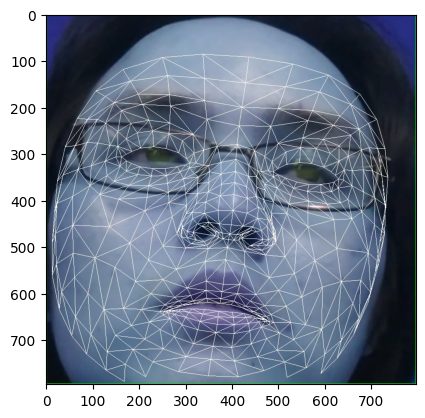

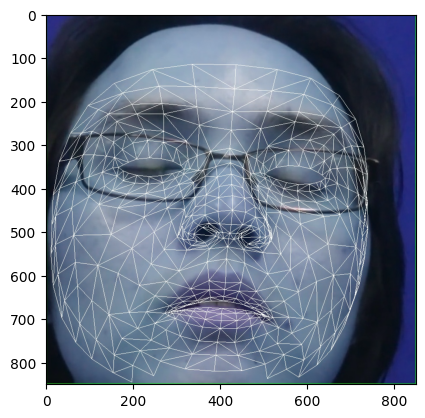

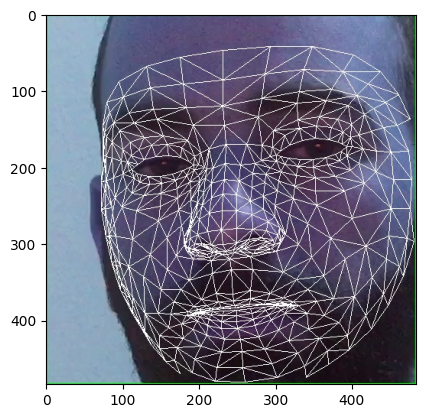

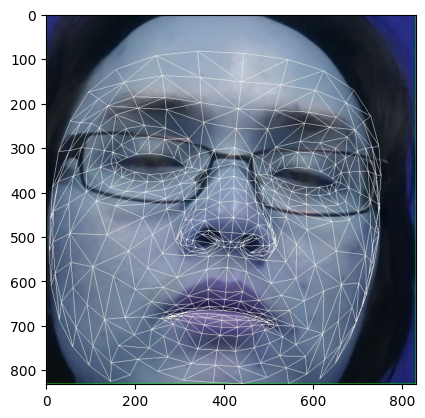

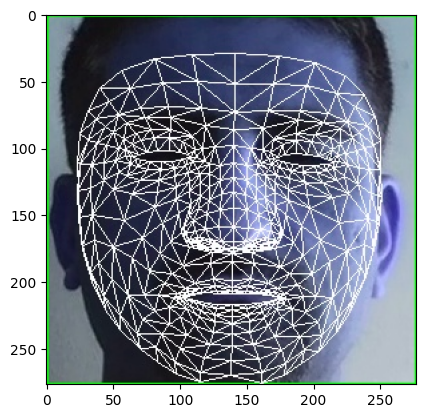

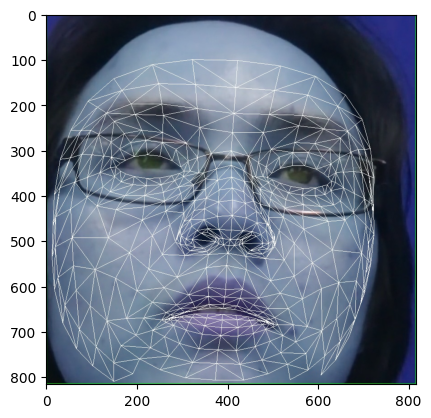

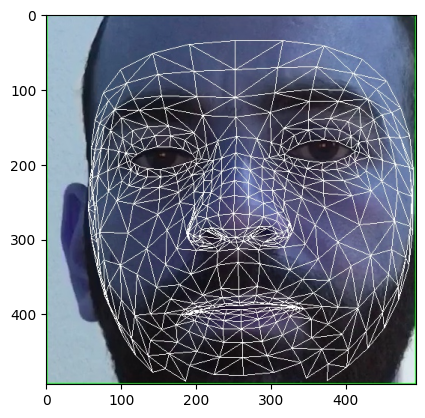

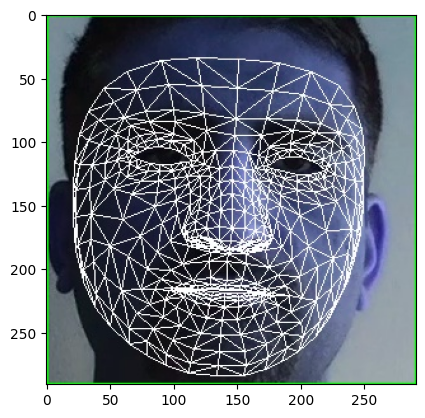

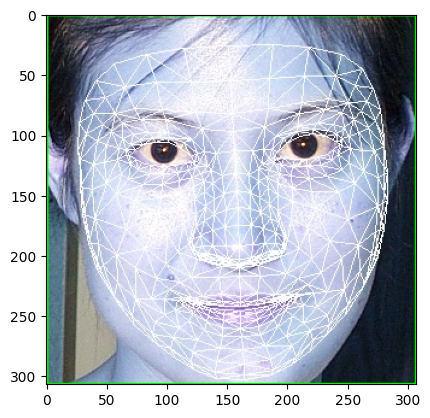

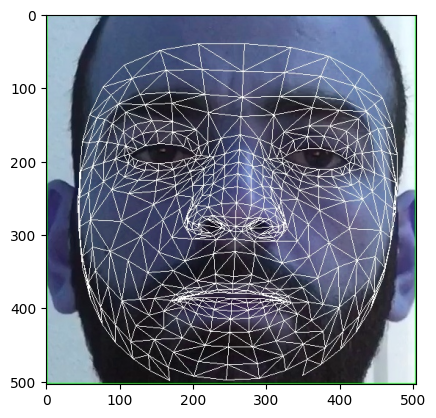

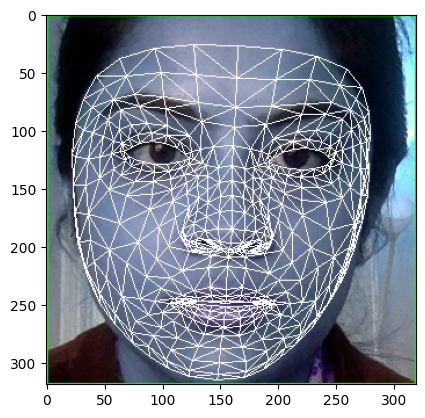

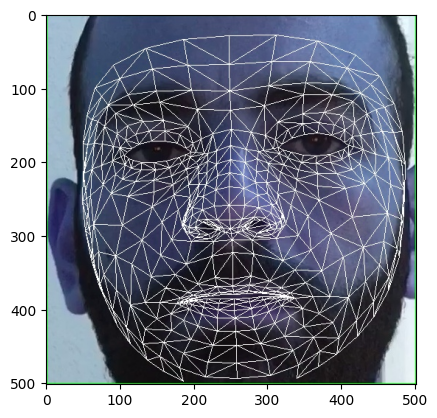

In [ ]:
categories = ["./content/drive/MyDrive/Visualize/archive/0 FaceImages/Fatigue Subjects", "./content/drive/MyDrive/Visualize/archive/0 FaceImages/Active Subjects"]
for category in categories:
  for idx, img in enumerate(os.listdir(f'./{category}')):
      if idx > 5:
        break
      img_file = cv2.imread(f'./{category}/{img}')
      plt.imshow(img_file)
      plt.show()
      plt.close()

In [ ]:
import os
import time
def face_for_yawn(direc="./"):
    yaw_no=[]
    i=1
    IMG_SIZE = 145
    categories = ["./content/drive/MyDrive/Visualize/archive/0 FaceImages/Fatigue Subjects", "./content/drive/MyDrive/Visualize/archive/0 FaceImages/Active Subjects"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            resized_array = cv2.resize(image_array, (IMG_SIZE, IMG_SIZE))
            yaw_no.append([resized_array, class_num1])
                #print('image face number '+str(i))
                #i=i+1
    return yaw_no
yawn_no_yawn = face_for_yawn()

0
1


In [ ]:
X = []
y = []
for feature, label in yawn_no_yawn:
    X.append(feature)
    y.append(label)

In [ ]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)
from sklearn.preprocessing import LabelEncoder
label_bin = LabelEncoder()
y = label_bin.fit_transform(y)
y = np.array(y)
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)
len(X_test)
len(X_train)

6038

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [ ]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [ ]:
from keras.layers import BatchNormalization
model = tf.keras.models.Sequential()
# Note the input shape is the desired size of the image 145 x 145 with 3 bytes color
# This is the first convolution
model.add(Conv2D(16, 3, activation='relu', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling2D())
tf.keras.layers.Dropout(0.1)
# The second convolution
model.add(Conv2D(32, 5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
tf.keras.layers.Dropout(0.1)
# The third convolution
model.add(Conv2D(64, 10, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
tf.keras.layers.Dropout(0.1)
# The fourth convolution
model.add(Conv2D(128, 12, activation='relu'))
model.add(BatchNormalization())

# Flatten the results to feed into a DNN
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
# Only 1 output neuron.
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 143, 143, 16)      448       
                                                                 
 batch_normalization_4 (Bat  (None, 143, 143, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 71, 71, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 67, 67, 32)        12832     
                                                                 
 batch_normalization_5 (Bat  (None, 67, 67, 32)        128       
 chNormalization)                                                
                                                      

In [ ]:
history = model.fit(train_generator, epochs=70, validation_data=test_generator)

Epoch 1/70
189/189 [==============================] - 212s 1s/step - loss: 0.4483 - accuracy: 0.7784 - val_loss: 1.3409 - val_accuracy: 0.5053
Epoch 2/70
189/189 [==============================] - 202s 1s/step - loss: 0.3790 - accuracy: 0.8254 - val_loss: 0.3518 - val_accuracy: 0.8311
Epoch 3/70
189/189 [==============================] - 200s 1s/step - loss: 0.3058 - accuracy: 0.8695 - val_loss: 0.5643 - val_accuracy: 0.7762
Epoch 4/70
189/189 [==============================] - 205s 1s/step - loss: 0.2819 - accuracy: 0.8799 - val_loss: 1.4499 - val_accuracy: 0.6497
Epoch 5/70
189/189 [==============================] - 198s 1s/step - loss: 0.2509 - accuracy: 0.8947 - val_loss: 0.2563 - val_accuracy: 0.8881
Epoch 6/70
189/189 [==============================] - 201s 1s/step - loss: 0.2338 - accuracy: 0.9026 - val_loss: 0.5051 - val_accuracy: 0.7960
Epoch 7/70
189/189 [==============================] - 209s 1s/step - loss: 0.2283 - accuracy: 0.9074 - val_loss: 0.3479 - val_accuracy: 0.8351

In [ ]:
# For RNN (LSTM) Model
from tensorflow.keras.layers import LSTM
# Reshape the input data for the RNN model
X_train_rnn = X_train.reshape(X_train.shape[0], -1, X_train.shape[3])
X_test_rnn = X_test.reshape(X_test.shape[0], -1, X_test.shape[3])

rnn_model = Sequential()
rnn_model.add(LSTM(units=64, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))


rnn_model.add(Dense(1, activation='sigmoid'))
rnn_model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
rnn_model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                17408     
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 17473 (68.25 KB)
Trainable params: 17473 (68.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
rnn_history = rnn_model.fit(X_train_rnn, y_train, epochs=70, validation_data=(X_test_rnn, y_test))



NameError: ignored

In [ ]:

# For DNN Model
dnn_model = Sequential()
dnn_model.add(Flatten(input_shape=X_train.shape[1:]))
dnn_model.add(Dense(128, activation='relu'))
dnn_model.add(Dropout(0.25))
dnn_model.add(Dense(64, activation='relu'))
dnn_model.add(Dense(1, activation='sigmoid'))
dnn_model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")

In [ ]:
dnn_history = dnn_model.fit(X_train, y_train, epochs=70, validation_data=(X_test, y_test))

In [ ]:
cnn_eval = cnn_model.evaluate(X_test, y_test)
rnn_eval = rnn_model.evaluate(X_test, y_test)
dnn_eval = dnn_model.evaluate(X_test, y_test)

# Print or log the evaluation results for each model
print("CNN Evaluation:", cnn_eval)
print("RNN Evaluation:", rnn_eval)
print("DNN Evaluation:", dnn_eval)